In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Twirler ( for later Use)

In [44]:
import re #because we need regular expressions
import numpy as np #because we need the random number generator
from qiskit import *
from qiskit.tools.monitor import job_monitor

import sys
sys.path.append('../')

from qiskit.aqua.utils import *

import numpy as np

Pauligateset=['id','x','y','z']

def equal(A, B, tolerance=1E-6, allowPhaseCheck=True):
    """
    Returns True if A and B are equal within tolerance tol, element-wise
    :param A: nxm matrix
    :param B: nxm matrix
    :param tolerance: Tolerance
    :param allowPhaseCheck: True if A and B should be considered equal if they are equal up to a complex phase factor
    :raises ValueError: if A, B not correct shape
    :return: True or False
    """
    dim0 = A.shape[0]
    dim1 = A.shape[1]
    if len(A.shape) > 2 or len(B.shape) > 2:
        raise ValueError("Both arguments must be n x m matrices.")
    if dim0 != B.shape[0] or dim1 != B.shape[1]:
        raise ValueError("Arguments must be of equal dimension.")

    checkPhase = False

    for ind in range(dim0):
        if checkPhase:
            break
        for j in range(dim1):
            num = np.absolute(A[ind, j] - B[ind, j])
            if num > tolerance:
                if allowPhaseCheck:
                    checkPhase = True  # There might be a (global) phase difference between the matrices
                else:
                    return False
                break

    if checkPhase:# Handle the case A = e^(i * theta) * B
        first = True
        eiPhase = 1

        for ind in range(dim0):
            for j in range(dim1):
                A_ij = A[ind, j]
                B_ij = B[ind, j]

                if np.absolute(A_ij) < tolerance:
                    A_ij = 0
                if np.absolute(B_ij) < tolerance:
                    B_ij = 0

                if A_ij == 0 and B_ij == 0:
                    continue
                elif (A_ij == 0 and B_ij != 0) or (A_ij != 0 and B_ij == 0):
                    # If one is zero, multiplying by phase factor does not change anything.
                    # Therefore, the other must be zero for the matrices to be equal up to a phase factor.
                    return False

                rel = A_ij / B_ij
                if np.absolute(np.absolute(rel) - 1) > tolerance:  # a/b must be 1.000... * e^(i * theta)
                    return False
                if first:
                    first = False
                    eiPhase = rel  # e ^(i * theta)
                if np.absolute(eiPhase - rel) > tolerance:
                    return False
    return True

def getPaulitwirlingPairsCX(printpairs=False):
    
    #making the gates
    
    ID1q = np.array([[1, 0], [0, 1]], dtype=np.complex_)
    sigmaX = np.array([[0, 1], [1, 0]], dtype=np.complex_)
    sigmaY = np.array([[0, 0 - 1.0j], [0 + 1.0j, 0]], dtype=np.complex_)
    sigmaZ = np.array([[1, 0], [0, -1]], dtype=np.complex_)

    ID2q = np.kron(ID1q, ID1q)

    tol = 1E-8

    paulis = np.array([ID1q, sigmaX, sigmaY, sigmaZ], dtype=np.complex_)

    cX = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=np.complex_)
    
    #some kind of new array

    pairs = np.zeros((4, 4, 2), dtype=int)
    
    #making all possible configurations for twirling (gates a,b,c,d)

    for a in range(4):  # sigma_control ^a
        pauli_ca = paulis[a]
        for b in range(4):  # sigma_target ^b
            pauli_tb = paulis[b]
            for c in range(4):  # sigma_control ^c
                pauli_cc = paulis[c]
                for d in range(4):  # sigma_target ^d
                    pauli_td = paulis[d]
                    LHS = np.kron(pauli_cc, pauli_td)
                    RHS = cX @ np.kron(pauli_ca, pauli_tb) @ cX.transpose().conjugate()
                    if equal(LHS, RHS, tol):
                        if printpairs:
                            print(Pauligateset[a],Pauligateset[b],Pauligateset[c],Pauligateset[d])
                        pairs[a][b][0] = c
                        pairs[a][b][1] = d
    return pairs

twirlingPairs = getPaulitwirlingPairsCX()

def create_Paulitwirled_and_noiseamplified_circuit(circuit,r,two_error_map,paulitwirling=True,controlledgatename='cx'):
    '''Pauli-twirl and amplify noise of controlled gates in a circuit
    Args:
        circuit: the original circuit
        r: noise amplification factor
        two_error_map: map of error rates of controlled gate between two qubits
        paulitwirling: turn Pauli-twirling on or off
        controlledgatename: name of the controlled gate to apply Pauli-twirling and error amplification to
    Returns:
        new circuit that is Pauli-twirled and errors are amplified by a factor for r
    '''
    newqasm_str=""
    qs=circuit.qasm()
    qregname=circuit.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith(controlledgatename):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1
            ## Apply Pauli-twirling
            if paulitwirling:
                indices_ab = np.random.randint(0, 4, 2)
                indices_cd = twirlingPairs[indices_ab[0]][indices_ab[1]]
                
                newqasm_str+="""barrier q[0],q[1];\n"""
                if indices_ab[0]>0:
                    newqasm_str+=Pauligateset[indices_ab[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_ab[1]>0:
                    newqasm_str+=Pauligateset[indices_ab[1]]+" "+qregname+"["+str(target_ind)+"];\n"
                    
                newqasm_str+=line+"\n"
                
                if indices_cd[0]>0:
                    newqasm_str+=Pauligateset[indices_cd[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_cd[1]>0:
                    newqasm_str+=Pauligateset[indices_cd[1]]+" "+qregname+"["+str(target_ind)+"];\n"
                newqasm_str+="""barrier q[0],q[1];\n"""
            else:
                newqasm_str+=line+"\n"
                

            ## increase the error rate of a cx gate
            if np.random.uniform(0, 1) < (r - 1) * two_error_map[control_ind][target_ind]:
                ### we need to avoid that the indentity is drawn for the control and the target qubit at the same time
                ### there are 4x4 combinations
                # I I    X I    Y I    Z I
                # I X    X X    Y X    Z X
                # I Y    X Y    Y Y    Z Y
                # I Z    X Z    Y Z    Z Z
                # with global indexation for random numbers
                # 0      4      8      12
                # 1      5      9      13
                # 2      6      10     14
                # 3      7      11     15
                # and local indexation
                # 0,0    1,0    2,0    3,0
                # 0,1    1,1    2,1    3,1
                # 0,2    1,2    2,2    3,2
                # 0,3    1,3    2,3    3,3
                # so we make sure to never draw 0 = (0,0) = I I
                newqasm_str+="""barrier q[0],q[1];\n"""
                ind_ef = np.random.randint(1, 16, 1)
                ind_e=int(int(ind_ef[0])/4)
                ind_f=ind_ef[0]%4
                if ind_e>0:
                    newqasm_str+=Pauligateset[ind_e]+" "+qregname+"["+str(control_ind)+"];\n"
                if ind_f>0:
                    newqasm_str+=Pauligateset[ind_f]+" "+qregname+"["+str(target_ind)+"];\n"
                newqasm_str+="""barrier q[0],q[1];\n"""
        else:
            newqasm_str+=line+"\n"
    #print(newqasm_str)
    circ=QuantumCircuit().from_qasm_str(newqasm_str)
    return circ

def Richardson_extrapolate(E, c):
    n=E.shape[0]
    if c.shape[0] != n:
        raise ValueError('E and c must have the same dimension.')
    if n<=1:
        raise ValueError('the dimension of E and c must be larger than 1.')
    A = np.zeros((n,n))
    b = np.zeros((n,1))
    #must sum to 1
    A[0,:] = 1
    b[0] = 1
    for k in range(1,n):
        A[k,:] = c**k
    x=np.linalg.solve(A,b)
    return np.dot(np.transpose(E),x)

def mitigate(circuit, amplification_factors,\
             expectationvalue_fun,\
             execution_backend, \
             experimentname, cx_error_map,\
             num_shots, num_experiments,\
             target_backend=None, noise_model=None, basis_gates=None,\
             paulitwirling=True, verbose=True):
    """
    it is of utter most importance, that the circit is executable on the backend that it is to be executed/targeted for
    target_backend: is used if execution_backend is a simulator
    noisemodel: is used if execution_backend is a simulator
    this function is implemented with convenience in mind, the classical part can be trivially made more memory efficient
    """
    optimization_level=1

    n_qubits = execution_backend.configuration().n_qubits
    is_simulator = execution_backend.configuration().simulator

    max_depth_dict={}
    mean_depth_dict={}
    max_depth_transpiled_dict={}
    mean_depth_transpiled_dict={}
    jobs_dict={}
    E_dict={}
    E_av_dict={}
    result_dict={}

    ### sanity checks
    if len(amplification_factors)<2:
        raise ValueError("specify at least 2 amplification factors, e.g., (1,2) ")
    if is_simulator:
        if target_backend == None:
            raise ValueError("you need to specify a taget backend")
        if noise_model == None:
            raise ValueError("you need to specify a noise model")
        if basis_gates == None:
            raise ValueError("you need to specify basis gates")
    else:
        execution_backend = target_backend

    if verbose:
        print("Sanity checks passed")

    if is_simulator:
        # in the case of a simulator,
        # we do not need to split the runs,
        # because max_experiments is not limited
        experimentname+="_backend"+execution_backend.name()
        experimentname+="_noisemodel"+target_backend.name()
        experimentname+="_shots"+str(num_shots)
        experimentname+="_experiments"+str(num_experiments)
        experimentname+="_paulitwirling"+str(paulitwirling)
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            result_dict[name] = read_results(name)
            if verbose:
                if result_dict[name] == None:
                    print("Could not read result for job '",name, "' from disk")
                else:
                    print("Result for job '",name, "' successfully read from disk")

            ### read circuit depth statistics from file
            if not result_dict[name] == None:
                with open('results/'+name+'.mean_circuit_depth','r') as f:
                    mean_depth_dict[name]=float(f.read())
                with open('results/'+name+'.max_circuit_depth','r') as f:
                    max_depth_dict[name]=float(f.read())
                with open('results/'+name+'.mean_transpiled_circuit_depth','r') as f:
                    mean_depth_transpiled_dict[name]=float(f.read())
                with open('results/'+name+'.max_transpiled_circuit_depth','r') as f:
                    max_depth_transpiled_dict[name]=float(f.read())

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            mean_depth=0
            max_depth=0
            mean_depth_transpiled=0
            max_depth_transpiled=0
            circuits_r=[]
            for p in range(1,num_experiments+1):
                if verbose and p%25==0:
                    print("Creating circuits for '",name, "'", p, "/",num_experiments, end='\r')
                circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                                    circuit, r, cx_error_map, paulitwirling)
                depth = circ_tmp.depth()
                mean_depth += depth
                max_depth = max(max_depth,depth)
                # now we can transpile to combine single qubit gates, etc.
                circ_tmp_transpiled=transpile(circ_tmp,\
                                              backend=target_backend,\
                                              optimization_level=optimization_level)
                circuits_r.append(circ_tmp_transpiled)
                depth=circ_tmp_transpiled.depth()
                mean_depth_transpiled += depth
                max_depth_transpiled = max(max_depth_transpiled,depth)
            if verbose:
                print("Creating circuits for '",name, "'", num_experiments, "/",num_experiments)
            max_depth_dict[name]=max_depth
            mean_depth_dict[name]=mean_depth/num_experiments
            max_depth_transpiled_dict[name]=max_depth_transpiled
            mean_depth_transpiled_dict[name]=mean_depth_transpiled/num_experiments
            if verbose:
                print("Starting job for '",name, "'")
            jobs_dict[name] = execute(circuits_r,\
                            execution_backend,\
                            noise_model=noise_model,\
                            basis_gates=basis_gates,\
                            shots=num_shots)

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            job_monitor(jobs_dict[name])
            success = write_results(name,jobs_dict[name])
            if verbose:
                if success:
                    print("Result for job '",name, "' successfully written to disk")
                else:
                    print("Could not write result for job '",name, "' from disk")

            ### write circuit depth statistics to file
            with open('results/'+name+'.mean_circuit_depth','w') as f:
                f.write(str(mean_depth_dict[name]))
            with open('results/'+name+'.max_circuit_depth','w') as f:
                f.write(str(max_depth_dict[name]))
            with open('results/'+name+'.mean_transpiled_circuit_depth','w') as f:
                f.write(str(mean_depth_transpiled_dict[name]))
            with open('results/'+name+'.max_transpiled_circuit_depth','w') as f:
                f.write(str(max_depth_transpiled_dict[name]))

        first=True
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if result_dict[name] == None:
                result_dict[name] = read_results(name)
            E_dict[name] = expectationvalue_fun(result_dict[name])
            E_av_dict[name] = np.zeros_like(E_dict[name])
            for j in range(1,num_experiments+1):
                E_av_dict[name][j-1] = sum(E_dict[name][0:j])/j
            if first:
                E_av=E_av_dict[name]
                first=False
            else:
                E_av=np.append(E_av,E_av_dict[name])## this is not very efficient coding

    else:
        raise ValueError("not yet implemented, coming soon")

    R=Richardson_extrapolate(E_av.reshape(len(amplification_factors),num_experiments),\
                             np.array(amplification_factors))


    return R, E_dict, E_av_dict,\
           max_depth_dict,mean_depth_dict,\
           max_depth_transpiled_dict,mean_depth_transpiled_dict,\
           experimentname
import numpy as np
import os
import datetime
import time
import pickle
from qiskit import *
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus

def start_or_retrieve_job(filename, backend, circuit=None, options=None):
    """function that
       1) retrieves the job from the backend if saved to file,
       2) or executes a job on a backend and saves it to file
    Parameters
    ----------
    filename : string
        The filename to write/read from. The extension ".job" is
        automatically appended to the string.
    backend : qiskit.providers.ibmq.ibmqbackend.IBMQBackend
        The backend where the job has been/is to be executed.
    circuit : qiskit.circuit.quantumcircuit.QuantumCircuit, optional
        The circuit that is to be executed.
    options: dict, optional
        The following is a list of all options and their default value
        options={'shots': 1024, 'forcererun': False, 'useapitoken': False, 'directory': 'jobs'}
        the directory is created if it does not exist
    Returns
    -------
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        
    """
    ### options parsing
    if options == None:
        options={}
    shots = options.get('shots', 1024)
    forcererun = options.get('forcererun', False)
    useapitoken = options.get('useapitoken', False)
    directory = options.get('directory', 'jobs')

    filename = filename+'.job'
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not(forcererun) and os.path.isfile(directory+'/'+filename):
        #read job id from file and retrieve the job
        with open(directory+'/'+filename, 'r') as f:
            apitoken = f.readline().rstrip()
            backendname = f.readline().rstrip()
            job_id = f.readline().rstrip()
        if useapitoken:
            IBMQ.save_account(apitoken, overwrite=True)
            IBMQ.load_account()
            provider = IBMQ.get_provider(hub='ibm-q')
            backend_tmp = provider.get_backend(backendname)
            if backend.name() != backend_tmp.name():
                raise Exception("The backend of the job was "+backend_tmp.name()+", but you requested "+backend.name())
            job = backend_tmp.retrieve_job(job_id)
        else:
            job = backend.retrieve_job(job_id)
    else:
        # otherwise start the job and write the id to file
        hasnotrun = True
        while hasnotrun:
            error = False
            try:
                job = execute(circuit, backend, shots=int(shots))
            except Exception as e:
                error = True
                sec  = 60
                if "Error code: 3458" in str(e):
                    print(filename +' No credits available, retry in '+str(sec)+' seconds'+', time='+str(datetime.datetime.now()), end='\r')
                else:
                    print('{j} Error! Code: {c}, Message: {m}, Time {t}'.format(j=str(filename), c = type(e).__name__, m = str(e), t=str(datetime.datetime.now())), ", retry in ",str(sec),' seconds', end='\r')
                time.sleep(sec)
            if not(error):
                hasnotrun = False
        job_id = job.job_id()
        apitoken = IBMQ.active_account()['token']
        backendname = backend.name()
        if job_id != '':
            file = open(directory+'/'+filename,'w')
            file.write(apitoken+'\n')
            file.write(backendname+'\n')
            file.write(job_id)
            file.close()
    return job

def write_results(filename, job, options=None):
    """function that writes the results of a job to file
    Parameters
    ----------
    filename : string
        The filename to write to. The extension ".result" is
        automatically appended to the string.
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        The job to get the results from
    options: dict, optional
        The following is a list of all options and their default value
        options={'overwrite': False, 'directory': 'results'}
    Returns
    -------
    success : bool
        set to True if the results from the job are written to file
        it is set to False, e.g., if the job has not yet finished successfully
    """
    ### options parsing
    if options == None:
        options={}
    overwrite = options.get('overwrite', False)
    directory = options.get('directory', 'results')

    filename=filename+'.result'
    if not os.path.exists(directory):
        os.makedirs(directory)

    success = False
    fileexists = os.path.isfile(directory+'/'+filename)
    if (fileexists and overwrite) or not(fileexists):
        jobstatus = job.status()
        if jobstatus == JobStatus.DONE:
            res=job.result().results
            tmpfile = open(directory+'/'+filename,'wb')
            pickle.dump(res,tmpfile)
            tmpfile.close()
            success = True
    return success

def read_results(filename, options=None):
    """function that reads results from file
    Parameters
    ----------
    filename : string
        The filename to read from. The extension ".result" is
        automatically appended to the string.
    options: dict, optional
        The following is a list of all options and their default value
        options={'directory': 'results'}
    Returns
    -------
    results : Object
        the form is dictated by job.result().results
        can be None, if the file does not exist
    success : bool
        set to True if the results 
    """
    ### options parsing
    if options == None:
        options={}
    directory = options.get('directory', 'results')

    filename=filename+'.result'

    results = None
    if os.path.isfile(directory+'/'+filename):
        tmpfile = open(directory+'/'+filename,'rb')
        results=pickle.load(tmpfile)
        tmpfile.close()
    return results

def get_id_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'id':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_U3_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'u3':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_T1(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][0]
        assert qubit.name == 'T1'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_T2(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][1]
        assert qubit.name == 'T2'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_readouterrors(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][3]
        assert qubit.name == 'readout_error'
        val.append(qubit.value)
    return val

def get_prob_meas0_prep1(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][4]
        assert qubit.name == 'prob_meas0_prep1'
        val.append(qubit.value)
    return val

def get_prob_meas1_prep0(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][5]
        assert qubit.name == 'prob_meas1_prep0'
        val.append(qubit.value)
    return val

def get_cx_error_map(backend):
    """
    function that returns a 2d array containing CX error rates.
    """
    num_qubits=backend.configuration().n_qubits
    two_qubit_error_map = np.zeros((num_qubits,num_qubits))
    backendproperties=backend.properties()
    gates=backendproperties.gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'cx':
            cxname = getattr(gates[i],'name')
            error = getattr(getattr(gates[i],'parameters')[0], 'value')
            #print(cxname, error)
            for p in range(num_qubits):
                for q in range(num_qubits):
                    if p==q:
                        continue
                    if cxname == 'cx'+str(p)+'_'+str(q):
                        two_qubit_error_map[p][q] = error
                        break
    return two_qubit_error_map

def getNumberOfControlledGates(circuit):
    """function that returns the number of CX, CY, CZ gates.
       N.B.: swap gates are counted as 3 CX gates.
    """
    numCx=0
    numCy=0
    numCz=0
    for instr, qargs, cargs in circuit.data:
        gate_string = instr.qasm()
        if gate_string == "swap":
            numCx += 3
        elif gate_string == "cx":
            numCx += 1
        elif gate_string == "cy":
            numCy += 1
        elif gate_string == "cz":
            numCz += 1
    return numCx, numCy, numCz

def convert_to_binarystring(results):
    list=[]
    for item in range(0,len(results)):
        dict={}
        co = results[item].data.counts
        for i in range(0,2**5):
            if(hasattr(co,hex(i))):
                binstring="{0:b}".format(i).zfill(5)
                counts = getattr(co, hex(i))
                dict[binstring] = counts
        list.append(dict)
    return list

In [20]:
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmqx2')
two_error_map =  get_cx_error_map(machine)

#noise model
noise_model = NoiseModel.from_backend(machine)

# Debugging VQE

## Some libraries

In [26]:
import warnings
from abc import ABC, abstractmethod
from typing import List, Optional, Union, Dict

import numpy as np
from qiskit.aqua.algorithms import AlgorithmResult
from qiskit.aqua.operators import OperatorBase, LegacyBaseOperator


class MinimumEigensolver(ABC):
    """The Minimum Eigensolver Interface.
    Algorithms that can compute a minimum eigenvalue for an operator
    may implement this interface to allow different algorithms to be
    used interchangeably.
    """

    @abstractmethod
    def compute_minimum_eigenvalue(
            self,
            operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
            aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                        LegacyBaseOperator]]]] = None
    ) -> 'MinimumEigensolverResult':
        """
        Computes minimum eigenvalue. Operator and aux_operators can be supplied here and
        if not None will override any already set into algorithm so it can be reused with
        different operators. While an operator is required by algorithms, aux_operators
        are optional. To 'remove' a previous aux_operators array use an empty list here.
        Args:
            operator: If not None replaces operator in algorithm
            aux_operators:  If not None replaces aux_operators in algorithm
        Returns:
            MinimumEigensolverResult
        """
        if operator is not None:
            self.operator = operator  # type: ignore
        if aux_operators is not None:
            self.aux_operators = aux_operators if aux_operators else None  # type: ignore
        return MinimumEigensolverResult()

    def supports_aux_operators(self) -> bool:
        """Whether computing the expectation value of auxiliary operators is supported.
        If the minimum eigensolver computes an eigenstate of the main operator then it
        can compute the expectation value of the aux_operators for that state. Otherwise
        they will be ignored.
        Returns:
            True if aux_operator expectations can be evaluated, False otherwise
        """
        return False

    @property  # type: ignore
    @abstractmethod
    def operator(self) -> Optional[Union[OperatorBase, LegacyBaseOperator]]:
        """Return the operator."""
        raise NotImplementedError

    @operator.setter  # type: ignore
    @abstractmethod
    def operator(self, operator: Union[OperatorBase, LegacyBaseOperator]) -> None:
        """Set the operator."""
        raise NotImplementedError

    @property  # type: ignore
    @abstractmethod
    def aux_operators(self) -> Optional[List[Optional[OperatorBase]]]:
        """Returns the auxiliary operators."""
        raise NotImplementedError

    @aux_operators.setter  # type: ignore
    @abstractmethod
    def aux_operators(self,
                      aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                                  LegacyBaseOperator]]]]) -> None:
        """Set the auxiliary operators."""
        raise NotImplementedError


class MinimumEigensolverResult(AlgorithmResult):
    """ Minimum Eigensolver Result."""

    @property
    def eigenvalue(self) -> Union[None, complex]:
        """ returns eigen value """
        return self.get('eigenvalue')

    @eigenvalue.setter
    def eigenvalue(self, value: complex) -> None:
        """ set eigen value """
        self.data['eigenvalue'] = value

    @property
    def eigenstate(self) -> Union[None, np.ndarray]:
        """ return eigen state """
        return self.get('eigenstate')

    @eigenstate.setter
    def eigenstate(self, value: np.ndarray) -> None:
        """ set eigen state """
        self.data['eigenstate'] = value

    @property
    def aux_operator_eigenvalues(self) -> Union[None, np.ndarray]:
        """ return aux operator eigen values """
        return self.get('aux_operator_eigenvalues')

    @aux_operator_eigenvalues.setter
    def aux_operator_eigenvalues(self, value: np.ndarray) -> None:
        """ set aux operator eigen values """
        self.data['aux_operator_eigenvalues'] = value

    @staticmethod
    def from_dict(a_dict: Dict) -> 'MinimumEigensolverResult':
        """ create new object from a dictionary """
        return MinimumEigensolverResult(a_dict)

    def __getitem__(self, key: object) -> object:
        if key == 'energy':
            warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else value.real
        elif key == 'energies':
            warnings.warn('energies deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else [value.real]
        elif key == 'eigvals':
            warnings.warn('eigvals deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else [value]
        elif key == 'eigvecs':
            warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
            value = super().__getitem__('eigenstate')
            return None if value is None else [value]
        elif key == 'aux_ops':
            warnings.warn('aux_ops deprecated, use aux_operator_eigenvalues property.',
                          DeprecationWarning)
            value = super().__getitem__('aux_operator_eigenvalues')
            return None if value is None else [value]

        return super().__getitem__(key)

In [27]:

"""The Variational Quantum Algorithm Base Class.
This class can be used an interface for working with Variation Quantum Algorithms, such as VQE,
QAOA, or QSVM, and also provides helper utilities for implementing new variational algorithms.
Writing a new variational algorithm is a simple as extending this class, implementing a cost
function for the new algorithm to pass to the optimizer, and running :meth:`find_minimum` method
of this class to carry out the optimization. Alternatively, all of the functions below can be
overridden to opt-out of this infrastructure but still meet the interface requirements.
"""

from typing import Optional, Callable, Union
import time
import logging
import warnings
from abc import abstractmethod
import numpy as np

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.providers import BaseBackend
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import AlgorithmResult, QuantumAlgorithm
from qiskit.aqua.components.optimizers import Optimizer, SLSQP
from qiskit.aqua.components.variational_forms import VariationalForm

logger = logging.getLogger(__name__)

# pylint: disable=invalid-name


class VQAlgorithm(QuantumAlgorithm):
    """The Variational Quantum Algorithm Base Class."""

    def __init__(self,
                 var_form: Union[QuantumCircuit, VariationalForm],
                 optimizer: Optimizer,
                 cost_fn: Optional[Callable] = None,
                 initial_point: Optional[np.ndarray] = None,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:
        """
        Args:
            var_form: An optional parameterized variational form (ansatz).
            optimizer: A classical optimizer.
            cost_fn: An optional cost function for optimizer. If not supplied here must be
                supplied on :meth:`find_minimum`.
            initial_point: An optional initial point (i.e. initial parameter values)
                for the optimizer.
            quantum_instance: Quantum Instance or Backend
        Raises:
             ValueError: for invalid input
        """
        super().__init__(quantum_instance)

        if optimizer is None:
            logger.info('No optimizer provided, setting it to SLSPQ.')
            optimizer = SLSQP()

        self._optimizer = optimizer
        self._cost_fn = cost_fn
        self._initial_point = initial_point
        self._var_form = var_form
        self._var_form_params = None
        if var_form is not None:
            self.var_form = var_form

        self._parameterized_circuits = None

    @property
    def var_form(self) -> Optional[Union[QuantumCircuit, VariationalForm]]:
        """ Returns variational form """
        return self._var_form

    @var_form.setter
    def var_form(self, var_form: Optional[Union[QuantumCircuit, VariationalForm]]):
        """ Sets variational form """
        if isinstance(var_form, QuantumCircuit):
            # store the parameters
            self._var_form_params = sorted(var_form.parameters, key=lambda p: p.name)
            self._var_form = var_form
        elif isinstance(var_form, VariationalForm):
            self._var_form_params = ParameterVector('θ', length=var_form.num_parameters)
            self._var_form = var_form
        elif var_form is None:
            self._var_form_params = None
            self._var_form = var_form
        else:
            raise ValueError('Unsupported type "{}" of var_form'.format(type(var_form)))

    @property
    def optimizer(self) -> Optional[Optimizer]:
        """ Returns optimizer """
        return self._optimizer

    @optimizer.setter
    def optimizer(self, optimizer: Optimizer):
        """ Sets optimizer """
        self._optimizer = optimizer

    @property
    def initial_point(self) -> Optional[np.ndarray]:
        """ Returns initial point """
        return self._initial_point

    @initial_point.setter
    def initial_point(self, initial_point: np.ndarray):
        """ Sets initial point """
        self._initial_point = initial_point

    def find_minimum(self,
                     initial_point: Optional[np.ndarray] = None,
                     var_form: Optional[Union[QuantumCircuit, VariationalForm]] = None,
                     cost_fn: Optional[Callable] = None,
                     optimizer: Optional[Optimizer] = None,
                     gradient_fn: Optional[Callable] = None) -> 'VQResult':
        """Optimize to find the minimum cost value.
        Args:
            initial_point: If not `None` will be used instead of any initial point supplied via
                constructor. If `None` and `None` was supplied to constructor then a random
                point will be used if the optimizer requires an initial point.
            var_form: If not `None` will be used instead of any variational form supplied via
                constructor.
            cost_fn: If not `None` will be used instead of any cost_fn supplied via
                constructor.
            optimizer: If not `None` will be used instead of any optimizer supplied via
                constructor.
            gradient_fn: Optional gradient function for optimizer
        Returns:
            dict: Optimized variational parameters, and corresponding minimum cost value.
        Raises:
            ValueError: invalid input
        """
        initial_point = initial_point if initial_point is not None else self.initial_point
        var_form = var_form if var_form is not None else self.var_form
        cost_fn = cost_fn if cost_fn is not None else self._cost_fn
        optimizer = optimizer if optimizer is not None else self.optimizer

        if var_form is None:
            raise ValueError('Variational form neither supplied to constructor nor find minimum.')
        if cost_fn is None:
            raise ValueError('Cost function neither supplied to constructor nor find minimum.')
        if optimizer is None:
            raise ValueError('Optimizer neither supplied to constructor nor find minimum.')

        nparms = var_form.num_parameters

        if hasattr(var_form, 'parameter_bounds') and var_form.parameter_bounds is not None:
            bounds = var_form.parameter_bounds
        else:
            bounds = [(None, None)] * nparms

        if initial_point is not None and len(initial_point) != nparms:
            raise ValueError(
                'Initial point size {} and parameter size {} mismatch'.format(
                    len(initial_point), nparms))
        if len(bounds) != nparms:
            raise ValueError('Variational form bounds size does not match parameter size')
        # If *any* value is *equal* in bounds array to None then the problem does *not* have bounds
        problem_has_bounds = not np.any(np.equal(bounds, None))
        # Check capabilities of the optimizer
        if problem_has_bounds:
            if not optimizer.is_bounds_supported:
                raise ValueError('Problem has bounds but optimizer does not support bounds')
        else:
            if optimizer.is_bounds_required:
                raise ValueError('Problem does not have bounds but optimizer requires bounds')
        if initial_point is not None:
            if not optimizer.is_initial_point_supported:
                raise ValueError('Optimizer does not support initial point')
        else:
            if optimizer.is_initial_point_required:
                if hasattr(var_form, 'preferred_init_points'):
                    # Note: default implementation returns None, hence check again after below
                    initial_point = var_form.preferred_init_points

                if initial_point is None:  # If still None use a random generated point
                    low = [(l if l is not None else -2 * np.pi) for (l, u) in bounds]
                    high = [(u if u is not None else 2 * np.pi) for (l, u) in bounds]
                    initial_point = self.random.uniform(low, high)

        start = time.time()
        if not optimizer.is_gradient_supported:  # ignore the passed gradient function
            gradient_fn = None

        logger.info('Starting optimizer.\nbounds=%s\ninitial point=%s', bounds, initial_point)
        opt_params, opt_val, num_optimizer_evals = optimizer.optimize(nparms,
                                                                      cost_fn,
                                                                      variable_bounds=bounds,
                                                                      initial_point=initial_point,
                                                                      gradient_function=gradient_fn)
        eval_time = time.time() - start

        result = VQResult()
        result.optimizer_evals = num_optimizer_evals
        result.optimizer_time = eval_time
        result.optimal_value = opt_val
        result.optimal_point = opt_params
        result.optimal_parameters = dict(zip(self._var_form_params, opt_params))

        return result

    def get_prob_vector_for_params(self, construct_circuit_fn, params_s,
                                   quantum_instance, construct_circuit_args=None):
        """ Helper function to get probability vectors for a set of params """
        circuits = []
        for params in params_s:
            circuit = construct_circuit_fn(params, **construct_circuit_args)
            circuits.append(circuit)
        results = quantum_instance.execute(circuits)

        probs_s = []
        for circuit in circuits:
            if quantum_instance.is_statevector:
                sv = results.get_statevector(circuit)
                probs = np.real(sv * np.conj(sv))
                probs_s.append(probs)
            else:
                counts = results.get_counts(circuit)
                probs_s.append(self.get_probabilities_for_counts(counts))
        return np.array(probs_s)

    def get_probabilities_for_counts(self, counts):
        """ get probabilities for counts """
        shots = sum(counts.values())
        states = int(2 ** len(list(counts.keys())[0]))
        probs = np.zeros(states)
        for k, v in counts.items():
            probs[int(k, 2)] = v / shots
        return probs

    @abstractmethod
    def get_optimal_cost(self):
        """ get optimal cost """
        raise NotImplementedError()

    @abstractmethod
    def get_optimal_circuit(self):
        """ get optimal circuit """
        raise NotImplementedError()

    @abstractmethod
    def get_optimal_vector(self):
        """ get optimal vector """
        raise NotImplementedError()

    @property
    @abstractmethod
    def optimal_params(self):
        """ returns optimal parameters """
        raise NotImplementedError()

    def cleanup_parameterized_circuits(self):
        """ set parameterized circuits to None """
        self._parameterized_circuits = None


class VQResult(AlgorithmResult):
    """ Variation Quantum Algorithm Result."""

    @property
    def optimizer_evals(self) -> int:
        """ Returns number of optimizer evaluations """
        return self.get('optimizer_evals')

    @optimizer_evals.setter
    def optimizer_evals(self, value: int) -> None:
        """ Sets number of optimizer evaluations """
        self.data['optimizer_evals'] = value

    @property
    def optimizer_time(self) -> float:
        """ Returns time taken for optimization """
        return self.get('optimizer_time')

    @optimizer_time.setter
    def optimizer_time(self, value: float) -> None:
        """ Sets time taken for optimization  """
        self.data['optimizer_time'] = value

    @property
    def optimal_value(self) -> float:
        """ Returns optimal value """
        return self.get('optimal_value')

    @optimal_value.setter
    def optimal_value(self, value: int) -> None:
        """ Sets optimal value """
        self.data['optimal_value'] = value

    @property
    def optimal_point(self) -> np.ndarray:
        """ Returns optimal point """
        return self.get('optimal_point')

    @optimal_point.setter
    def optimal_point(self, value: np.ndarray) -> None:
        """ Sets optimal point """
        self.data['optimal_point'] = value

    @property
    def optimal_parameters(self) -> dict:
        """ Returns the optimal parameters in a dictionary """
        return self.get('optimal_parameters')

    @optimal_parameters.setter
    def optimal_parameters(self, value: dict) -> None:
        """ Sets optimal parameters """
        self.data['optimal_parameters'] = value

    def __getitem__(self, key: object) -> object:
        if key == 'num_optimizer_evals':
            warnings.warn('num_optimizer_evals deprecated, use optimizer_evals property.',
                          DeprecationWarning)
            return super().__getitem__('optimizer_evals')
        elif key == 'min_val':
            warnings.warn('min_val deprecated, use optimal_value property.',
                          DeprecationWarning)
            return super().__getitem__('optimal_value')
        elif key == 'opt_params':
            warnings.warn('opt_params deprecated, use optimal_point property.',
                          DeprecationWarning)
            return super().__getitem__('optimal_point')
        elif key == 'eval_time':
            warnings.warn('eval_time deprecated, use optimizer_time property.',
                          DeprecationWarning)
            return super().__getitem__('optimizer_time')


## VQE

In [28]:
from typing import Optional, List, Callable, Union, Dict
import logging
import warnings
from time import time
import numpy as np

from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.providers import BaseBackend
from qiskit.aqua import QuantumInstance, AquaError
from qiskit.aqua.algorithms import QuantumAlgorithm
from qiskit.aqua.operators import (OperatorBase, ExpectationBase, ExpectationFactory, StateFn,
                                   CircuitStateFn, LegacyBaseOperator, ListOp, I, CircuitSampler)
from qiskit.aqua.components.optimizers import Optimizer, SLSQP
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.utils.validation import validate_min
#from ..vq_algorithm import VQAlgorithm, VQResult
#from .minimum_eigen_solver import MinimumEigensolver, MinimumEigensolverResult

logger = logging.getLogger(__name__)

# disable check for var_forms, optimizer setter because of pylint bug
# pylint: disable=no-member


class VQE_mod(VQAlgorithm, MinimumEigensolver):
    r"""The Variational Quantum Eigensolver algorithm.

    `VQE <https://arxiv.org/abs/1304.3061>`__ is a hybrid algorithm that uses a
    variational technique and interleaves quantum and classical computations in order to find
    the minimum eigenvalue of the Hamiltonian :math:`H` of a given system.

    An instance of VQE requires defining two algorithmic sub-components:
    a trial state (ansatz) from Aqua's :mod:`~qiskit.aqua.components.variational_forms`, and one
    of the classical :mod:`~qiskit.aqua.components.optimizers`. The ansatz is varied, via its set
    of parameters, by the optimizer, such that it works towards a state, as determined by the
    parameters applied to the variational form, that will result in the minimum expectation value
    being measured of the input operator (Hamiltonian).

    An optional array of parameter values, via the *initial_point*, may be provided as the
    starting point for the search of the minimum eigenvalue. This feature is particularly useful
    such as when there are reasons to believe that the solution point is close to a particular
    point.  As an example, when building the dissociation profile of a molecule,
    it is likely that using the previous computed optimal solution as the starting
    initial point for the next interatomic distance is going to reduce the number of iterations
    necessary for the variational algorithm to converge.  Aqua provides an
    `initial point tutorial <https://github.com/Qiskit/qiskit-tutorials-community/blob/master
    /chemistry/h2_vqe_initial_point.ipynb>`__ detailing this use case.

    The length of the *initial_point* list value must match the number of the parameters
    expected by the variational form being used. If the *initial_point* is left at the default
    of ``None``, then VQE will look to the variational form for a preferred value, based on its
    given initial state. If the variational form returns ``None``,
    then a random point will be generated within the parameter bounds set, as per above.
    If the variational form provides ``None`` as the lower bound, then VQE
    will default it to :math:`-2\pi`; similarly, if the variational form returns ``None``
    as the upper bound, the default value will be :math:`2\pi`.

    .. note::

        The VQE stores the parameters of ``var_form`` sorted by name to map the values
        provided by the optimizer to the circuit. This is done to ensure reproducible results,
        for example such that running the optimization twice with same random seeds yields the
        same result. Also, the ``optimal_point`` of the result object can be used as initial
        point of another VQE run by passing it as ``initial_point`` to the initializer.

    """

    def __init__(self,
                 operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
                 var_form: Optional[Union[QuantumCircuit, VariationalForm]] = None,
                 optimizer: Optional[Optimizer] = None,
                 initial_point: Optional[np.ndarray] = None,
                 expectation: Optional[ExpectationBase] = None,
                 include_custom: bool = False,
                 max_evals_grouped: int = 1,
                 aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                             LegacyBaseOperator]]]] = None,
                 callback: Optional[Callable[[int, np.ndarray, float, float], None]] = None,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:
        """

        Args:
            operator: Qubit operator of the Observable
            var_form: A parameterized circuit used as Ansatz for the wave function.
            optimizer: A classical optimizer.
            initial_point: An optional initial point (i.e. initial parameter values)
                for the optimizer. If ``None`` then VQE will look to the variational form for a
                preferred point and if not will simply compute a random one.
            expectation: The Expectation converter for taking the average value of the
                Observable over the var_form state function. When ``None`` (the default) an
                :class:`~qiskit.aqua.operators.expectations.ExpectationFactory` is used to select
                an appropriate expectation based on the operator and backend. When using Aer
                qasm_simulator backend, with paulis, it is however much faster to leverage custom
                Aer function for the computation but, although VQE performs much faster
                with it, the outcome is ideal, with no shot noise, like using a state vector
                simulator. If you are just looking for the quickest performance when choosing Aer
                qasm_simulator and the lack of shot noise is not an issue then set `include_custom`
                parameter here to ``True`` (defaults to ``False``).
            include_custom: When `expectation` parameter here is None setting this to ``True`` will
                allow the factory to include the custom Aer pauli expectation.
            max_evals_grouped: Max number of evaluations performed simultaneously. Signals the
                given optimizer that more than one set of parameters can be supplied so that
                potentially the expectation values can be computed in parallel. Typically this is
                possible when a finite difference gradient is used by the optimizer such that
                multiple points to compute the gradient can be passed and if computed in parallel
                improve overall execution time.
            aux_operators: Optional list of auxiliary operators to be evaluated with the
                eigenstate of the minimum eigenvalue main result and their expectation values
                returned. For instance in chemistry these can be dipole operators, total particle
                count operators so we can get values for these at the ground state.
            callback: a callback that can access the intermediate data during the optimization.
                Four parameter values are passed to the callback as follows during each evaluation
                by the optimizer for its current set of parameters as it works towards the minimum.
                These are: the evaluation count, the optimizer parameters for the
                variational form, the evaluated mean and the evaluated standard deviation.`
            quantum_instance: Quantum Instance or Backend
        """
        validate_min('max_evals_grouped', max_evals_grouped, 1)
        if var_form is None:
            var_form = RealAmplitudes()

        if optimizer is None:
            optimizer = SLSQP()

        # set the initial point to the preferred parameters of the variational form
        if initial_point is None and hasattr(var_form, 'preferred_init_points'):
            initial_point = var_form.preferred_init_points

        self._max_evals_grouped = max_evals_grouped
        self._circuit_sampler = None
        self._expectation = expectation
        self._include_custom = include_custom
        self._expect_op = None
        self._operator = None

        super().__init__(var_form=var_form,
                         optimizer=optimizer,
                         cost_fn=self._energy_evaluation,
                         initial_point=initial_point,
                         quantum_instance=quantum_instance)
        self._ret = None
        self._eval_time = None
        self._optimizer.set_max_evals_grouped(max_evals_grouped)
        self._callback = callback

        if operator is not None:
            self.operator = operator
        self.aux_operators = aux_operators

        self._eval_count = 0
        logger.info(self.print_settings())

    @property
    def operator(self) -> Optional[OperatorBase]:
        """ Returns operator """
        return self._operator

    @operator.setter
    def operator(self, operator: Union[OperatorBase, LegacyBaseOperator]) -> None:
        """ set operator """
        if isinstance(operator, LegacyBaseOperator):
            operator = operator.to_opflow()
        self._operator = operator
        self._expect_op = None
        self._check_operator_varform()
        if self._expectation is None:
            self._try_set_expectation_value_from_factory()

    def _try_set_expectation_value_from_factory(self):
        if self.operator and self.quantum_instance:
            self.expectation = ExpectationFactory.build(operator=self.operator,
                                                        backend=self.quantum_instance,
                                                        include_custom=self._include_custom)

    @QuantumAlgorithm.quantum_instance.setter
    def quantum_instance(self, quantum_instance: Union[QuantumInstance, BaseBackend]) -> None:
        """ set quantum_instance """
        super(VQE, self.__class__).quantum_instance.__set__(self, quantum_instance)

        if self._circuit_sampler is None:
            self._circuit_sampler = CircuitSampler(self._quantum_instance)
        else:
            self._circuit_sampler.quantum_instance = self._quantum_instance

        if self._expectation is None:
            self._try_set_expectation_value_from_factory()

    @property
    def expectation(self) -> ExpectationBase:
        """ The expectation value algorithm used to construct the expectation measurement from
        the observable. """
        return self._expectation

    @expectation.setter
    def expectation(self, exp: ExpectationBase) -> None:
        self._expectation = exp
        self._expect_op = None

    @property
    def aux_operators(self) -> Optional[List[Optional[OperatorBase]]]:
        """ Returns aux operators """
        return self._aux_operators

    @aux_operators.setter
    def aux_operators(self,
                      aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                                  LegacyBaseOperator]]]]) -> None:
        """ Set aux operators """
        # We need to handle the array entries being Optional i.e. having value None
        self._aux_op_nones = None
        if isinstance(aux_operators, list):
            self._aux_op_nones = [op is None for op in aux_operators]
            zero_op = I.tensorpower(self.operator.num_qubits) * 0.0
            converted = [op.to_opflow() if op else zero_op for op in aux_operators]
            # For some reason Chemistry passes aux_ops with 0 qubits and paulis sometimes.
            converted = [zero_op if op == 0 else op for op in converted]
            aux_operators = ListOp(converted)
        elif isinstance(aux_operators, LegacyBaseOperator):
            aux_operators = [aux_operators.to_opflow()]
        self._aux_operators = aux_operators

    def _check_operator_varform(self):
        """Check that the number of qubits of operator and variational form match."""
        if self.operator is not None and self.var_form is not None:
            if self.operator.num_qubits != self.var_form.num_qubits:
                # try to set the number of qubits on the variational form, if possible
                try:
                    self.var_form.num_qubits = self.operator.num_qubits
                    self._var_form_params = sorted(self.var_form.parameters, key=lambda p: p.name)
                except AttributeError:
                    raise AquaError("The number of qubits of the variational form does not match "
                                    "the operator, and the variational form does not allow setting "
                                    "the number of qubits using `num_qubits`.")

    @VQAlgorithm.optimizer.setter
    def optimizer(self, optimizer: Optimizer):
        """ Sets optimizer """
        super(VQE, self.__class__).optimizer.__set__(self, optimizer)
        if optimizer is not None:
            optimizer.set_max_evals_grouped(self._max_evals_grouped)

    @property
    def setting(self):
        """Prepare the setting of VQE as a string."""
        ret = "Algorithm: {}\n".format(self.__class__.__name__)
        params = ""
        for key, value in self.__dict__.items():
            if key[0] == "_":
                if "initial_point" in key and value is None:
                    params += "-- {}: {}\n".format(key[1:], "Random seed")
                else:
                    params += "-- {}: {}\n".format(key[1:], value)
        ret += "{}".format(params)
        return ret

    def print_settings(self):
        """
        Preparing the setting of VQE into a string.

        Returns:
            str: the formatted setting of VQE
        """
        ret = "\n"
        ret += "==================== Setting of {} ============================\n".format(
            self.__class__.__name__)
        ret += "{}".format(self.setting)
        ret += "===============================================================\n"
        if hasattr(self._var_form, 'setting'):
            ret += "{}".format(self._var_form.setting)
        elif hasattr(self._var_form, 'print_settings'):
            ret += "{}".format(self._var_form.print_settings())
        elif isinstance(self._var_form, QuantumCircuit):
            ret += "var_form is a custom circuit"
        else:
            ret += "var_form has not been set"
        ret += "===============================================================\n"
        ret += "{}".format(self._optimizer.setting)
        ret += "===============================================================\n"
        return ret


    def construct_circuit(self,
                          parameter: Union[List[float], List[Parameter], np.ndarray]
                          ) -> OperatorBase:
        r"""
        Generate the ansatz circuit and expectation value measurement, and return their
        runnable composition.

        Args:
            parameter: Parameters for the ansatz circuit.

        Returns:
            The Operator equalling the measurement of the ansatz :class:`StateFn` by the
            Observable's expectation :class:`StateFn`.

        Raises:
            AquaError: If no operator has been provided.
        """
        if self.operator is None:
            raise AquaError("The operator was never provided.")

        # ensure operator and varform are compatible
        self._check_operator_varform()

        if isinstance(self.var_form, QuantumCircuit):
            param_dict = dict(zip(self._var_form_params, parameter))
            wave_function = self.var_form.assign_parameters(param_dict)
        else:
            wave_function = self.var_form.construct_circuit(parameter)

        # If ExpectationValue was never created, create one now.
        if not self.expectation:
            self._try_set_expectation_value_from_factory()

        observable_meas = self.expectation.convert(StateFn(self.operator, is_measurement=True))
        ansatz_circuit_op = CircuitStateFn(wave_function)
        return observable_meas.compose(ansatz_circuit_op).reduce()


    def supports_aux_operators(self) -> bool:
        return True


    def _run(self) -> 'VQEResult':
        """Run the algorithm to compute the minimum eigenvalue.

        Returns:
            The result of the VQE algorithm as ``VQEResult``.

        Raises:
            AquaError: Wrong setting of operator and backend.
        """
        if self.operator is None:
            raise AquaError("The operator was never provided.")

        self._check_operator_varform()

        self._quantum_instance.circuit_summary = True

        self._eval_count = 0
        vqresult = self.find_minimum(initial_point=self.initial_point,
                                     var_form=self.var_form,
                                     cost_fn=self._energy_evaluation,
                                     optimizer=self.optimizer)

        # TODO remove all former dictionary logic
        self._ret = {}
        self._ret['num_optimizer_evals'] = vqresult.optimizer_evals
        self._ret['min_val'] = vqresult.optimal_value
        self._ret['opt_params'] = vqresult.optimal_point
        self._ret['eval_time'] = vqresult.optimizer_time
        self._ret['opt_params_dict'] = vqresult.optimal_parameters

        if self._ret['num_optimizer_evals'] is not None and \
                self._eval_count >= self._ret['num_optimizer_evals']:
            self._eval_count = self._ret['num_optimizer_evals']
        self._eval_time = self._ret['eval_time']
        logger.info('Optimization complete in %s seconds.\nFound opt_params %s in %s evals',
                    self._eval_time, self._ret['opt_params'], self._eval_count)
        self._ret['eval_count'] = self._eval_count

        self._ret['energy'] = self.get_optimal_cost()
        self._ret['eigvals'] = np.asarray([self._ret['energy']])
        self._ret['eigvecs'] = np.asarray([self.get_optimal_vector()])

        result = VQEResult()
        result.combine(vqresult)
        result.eigenvalue = vqresult.optimal_value + 0j
        result.eigenstate = self.get_optimal_vector()

        if self.aux_operators:
            self._eval_aux_ops()
            # TODO remove when ._ret is deprecated
            result.aux_operator_eigenvalues = self._ret['aux_ops'][0]

        result.cost_function_evals = self._eval_count

        return result

    def _eval_aux_ops(self, threshold=1e-12):
        # Create new CircuitSampler to avoid breaking existing one's caches.
        sampler = CircuitSampler(self.quantum_instance)

        aux_op_meas = self.expectation.convert(StateFn(self.aux_operators, is_measurement=True))
        aux_op_expect = aux_op_meas.compose(CircuitStateFn(self.get_optimal_circuit()))
        values = np.real(sampler.convert(aux_op_expect).eval())

        # Discard values below threshold
        aux_op_results = (values * (np.abs(values) > threshold))
        # Deal with the aux_op behavior where there can be Nones or Zero qubit Paulis in the list
        self._ret['aux_ops'] = [None if is_none else [result]
                                for (is_none, result) in zip(self._aux_op_nones, aux_op_results)]
        self._ret['aux_ops'] = np.array([self._ret['aux_ops']])

    def compute_minimum_eigenvalue(
            self,
            operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
            aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                        LegacyBaseOperator]]]] = None
    ) -> MinimumEigensolverResult:
        super().compute_minimum_eigenvalue(operator, aux_operators)
        return self._run()


    def _energy_evaluation(self, parameters: Union[List[float], np.ndarray]
                           ) -> Union[float, List[float]]:
        """Evaluate energy at given parameters for the variational form.

        This is the objective function to be passed to the optimizer that is used for evaluation.

        Args:
            parameters: The parameters for the variational form.

        Returns:
            Energy of the hamiltonian of each parameter.


        Raises:
            RuntimeError: If the variational form has no parameters.
        """
        if not self._expect_op:
            self._expect_op = self.construct_circuit(self._var_form_params)

        num_parameters = self.var_form.num_parameters
        if self._var_form.num_parameters == 0:
            raise RuntimeError('The var_form cannot have 0 parameters.')

        parameter_sets = np.reshape(parameters, (-1, num_parameters))
        # Create dict associating each parameter with the lists of parameterization values for it
        param_bindings = dict(zip(self._var_form_params, parameter_sets.transpose().tolist()))

        start_time = time()
        sampled_expect_op = self._circuit_sampler.convert(self._expect_op, params=param_bindings)
        means = np.real(sampled_expect_op.eval())

        if self._callback is not None:
            variance = np.real(self._expectation.compute_variance(sampled_expect_op))
            estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)
            for i, param_set in enumerate(parameter_sets):
                self._eval_count += 1
                self._callback(self._eval_count, param_set, means[i], estimator_error[i])
        else:
            self._eval_count += len(means)

        end_time = time()
        logger.info('Energy evaluation returned %s - %.5f (ms), eval count: %s',
                    means, (end_time - start_time) * 1000, self._eval_count)
        print("Inside _energy_evaluation, means is " + str(means))
        return means if len(means) > 1 else means[0]

    def get_optimal_cost(self) -> float:
        """Get the minimal cost or energy found by the VQE."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot return optimal cost before running the "
                            "algorithm to find optimal params.")
        return self._ret['min_val']


    def get_optimal_circuit(self) -> QuantumCircuit:
        """Get the circuit with the optimal parameters."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal circuit before running the "
                            "algorithm to find optimal params.")
        if isinstance(self.var_form, VariationalForm):
            return self._var_form.construct_circuit(self._ret['opt_params'])
        return self.var_form.assign_parameters(self._ret['opt_params_dict'])


    def get_optimal_vector(self) -> Union[List[float], Dict[str, int]]:
        """Get the simulation outcome of the optimal circuit. """
        # pylint: disable=import-outside-toplevel
        from qiskit.aqua.utils.run_circuits import find_regs_by_name

        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal vector before running the "
                            "algorithm to find optimal params.")
        qc = self.get_optimal_circuit()
        if self._quantum_instance.is_statevector:
            ret = self._quantum_instance.execute(qc)
            self._ret['min_vector'] = ret.get_statevector(qc)
        else:
            c = ClassicalRegister(qc.width(), name='c')
            q = find_regs_by_name(qc, 'q')
            qc.add_register(c)
            qc.barrier(q)
            qc.measure(q, c)
            ret = self._quantum_instance.execute(qc)
            self._ret['min_vector'] = ret.get_counts(qc)
        return self._ret['min_vector']


    @property
    def optimal_params(self) -> List[float]:
        """The optimal parameters for the variational form."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal params before running the algorithm.")
        return self._ret['opt_params']



class VQEResult(VQResult, MinimumEigensolverResult):
    """ VQE Result."""

    @property
    def cost_function_evals(self) -> int:
        """ Returns number of cost optimizer evaluations """
        return self.get('cost_function_evals')

    @cost_function_evals.setter
    def cost_function_evals(self, value: int) -> None:
        """ Sets number of cost function evaluations """
        self.data['cost_function_evals'] = value

    def __getitem__(self, key: object) -> object:
        if key == 'eval_count':
            warnings.warn('eval_count deprecated, use cost_function_evals property.',
                          DeprecationWarning)
            return super().__getitem__('cost_function_evals')

        try:
            return VQResult.__getitem__(self, key)
        except KeyError:
            return MinimumEigensolverResult.__getitem__(self, key)

# IDeal VQE

In [29]:
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries

In [30]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    print(qubitOp.print_details())
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [33]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA


simulator = Aer.get_backend('qasm_simulator')

# creating a list of distances to run VQE on 
exact_energy = 0
vqe_energy = 0
dist = 0.74

optimizer = COBYLA(maxiter=2000)
qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
# Finding exact energies to show how off VQE was from exact energy curve
result = ExactEigensolver(qubitOp).run()
exact_energy = result['energy'] + shift

# Initial STate 
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    'parity'
) 
print('Number of qubits are : ' + str(qubitOp.num_qubits))
# UCCSD Variational Form
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)
# Running VQE 
vqe = VQE(qubitOp, var_form, optimizer)
vqe_energy = vqe.run(simulator)['energy'] + shift

print('Exact Energy is ' + str(exact_energy))
print('VQE energy is '+ str(vqe_energy))



HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
II	(-1.0534210769165182+0j)
IZ	(0.3948443633559045+0j)
ZI	(-0.39484436335590456+0j)
ZZ	(-0.01124615715082089+0j)
XX	(0.1812104620151972+0j)

Number of qubits are : 2
Exact Energy is -1.1372838344885008
VQE energy is -1.1150547259335688


In [34]:
vqe.run(simulator)['energy']

-1.85160756727042

In [35]:
Hamiltonian = """II
IZ 
ZI
ZZ
XX"""
Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]

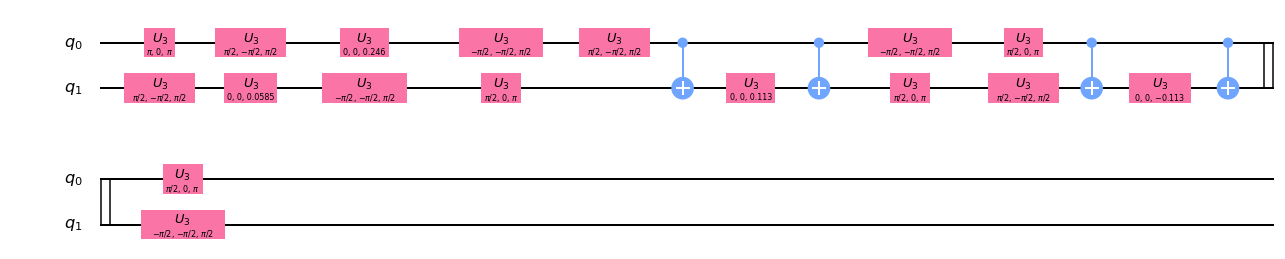

In [36]:
vqe_circ = vqe.get_optimal_circuit().decompose().decompose()
vqe_circ.draw(output = 'mpl')

In [40]:
from qiskit import ClassicalRegister

circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            circ.h(index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

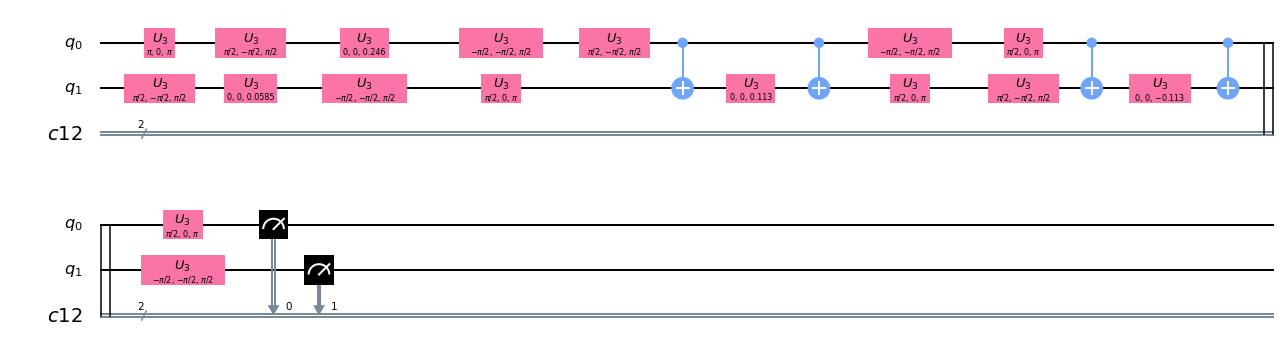

In [57]:
#Sanity check .... fifth hammy is XX
circuits[1].draw(output = 'mpl')

### Twirling Each of these hammyfied circuits 512 times

In [45]:
# 5 noise scalings 
scale = 5
lots_scaled_circuits = []

for c in range(1, scale+1):
    scale_circs = []
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in circuits: 
        hammyfied_circs = []
        print( "Starting Hammified Circ")
        for i in range(512):
            #debugg 
            if (i%50 == 0): 
                print(str(i) + ' circuits done')
            circ = hammyfied_circ.copy()
            circ = create_Paulitwirled_and_noiseamplified_circuit(circ,c,two_error_map)
            hammyfied_circs.append(circ)
        scale_circs.append(hammyfied_circs)
    lots_scaled_circuits.append(scale_circs)
    
    

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits do

In [46]:
#Firing up noisy sim 
from qiskit.aqua import QuantumInstance
##Simulate noise of IBMQ yorktown 
##noisy_sim = QuantumInstance(backend=simulator, noise_model=noise_model )
# Get coupling map from backend
coupling_map = machine.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates



## Running Those Circs on Noisy Simulator 

### Not values but results

#### Expectation Values


In [47]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [77]:
def get_expec_val_H2(results, h):
    keys = results.get_counts().keys()
    e_val = 0
    for key in keys:
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(results.get_counts()[key])/1024)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(results.get_counts()[key])/1024)
            else: 
                e_val += (int(results.get_counts()[key])/1024)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(results.get_counts()[key])/1024)
            else: 
                e_val += (int(results.get_counts()[key])/1024)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(results.get_counts()[key])/1024)
            else:
                e_val += (-1)*(int(results.get_counts()[key])/1024)
    return e_val
    

### Running the Circuits

In [74]:
from qiskit import execute 
from qiskit.compiler import transpile 

lots_scaled_results = []
for scale_circs in lots_scaled_circuits:
    print('------------------------------Starting Scale ---------------------')
    scale_results = []
    for hammyfied_circs in scale_circs:
        print( "Starting Hammified Circs")
        hammyfied_results = []
        for circ in hammyfied_circs: 
            circ = transpile(circ, basis_gates = basis_gates)
            job =  execute(circ, simulator,
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_model, shots = 1024)
            result = job.result()
            #expec_val = get_expec_val(result)
            hammyfied_results.append(result)
        scale_results.append(hammyfied_results)
    lots_scaled_results.append(scale_results)

------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs


In [83]:
# Made an error, instead of putting in counts, put results
lots_scaled_values = []

for scale_results in lots_scaled_results: 
    scale_values = []
    n = len(scale_results) #if 5 hammys, then length is 5
    for i in range(n): 
        hammyfied_vals = []
        for result in scale_results[i]: 
            hammyfied_val = get_expec_val_H2(result, i)
            if (i==0): 
                print(hammyfied_val)
            hammyfied_vals.append(hammyfied_val)
        scale_values.append(hammyfied_vals)
    lots_scaled_values.append(scale_values)
            

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [85]:
lots_scaled_values[0][1]

[-0.7578125,
 -0.7578125,
 -0.783203125,
 -0.7890625,
 -0.7578125,
 -0.7734375,
 -0.77734375,
 -0.798828125,
 -0.826171875,
 -0.791015625,
 -0.7734375,
 -0.771484375,
 -0.81640625,
 -0.8203125,
 -0.77734375,
 -0.8046875,
 -0.73046875,
 -0.7890625,
 -0.74609375,
 -0.767578125,
 -0.783203125,
 -0.810546875,
 -0.77734375,
 -0.779296875,
 -0.76171875,
 -0.83203125,
 -0.791015625,
 -0.822265625,
 -0.7890625,
 -0.8203125,
 -0.796875,
 -0.7890625,
 -0.77734375,
 -0.794921875,
 -0.7890625,
 -0.833984375,
 -0.783203125,
 -0.7890625,
 -0.798828125,
 -0.82421875,
 -0.779296875,
 -0.775390625,
 -0.810546875,
 -0.767578125,
 -0.775390625,
 -0.767578125,
 -0.787109375,
 -0.78515625,
 -0.798828125,
 -0.779296875,
 -0.794921875,
 -0.818359375,
 -0.794921875,
 -0.75,
 -0.7578125,
 -0.796875,
 -0.82421875,
 -0.798828125,
 -0.80859375,
 -0.82421875,
 -0.798828125,
 -0.78125,
 -0.76953125,
 -0.8046875,
 -0.826171875,
 -0.77734375,
 -0.748046875,
 -0.7734375,
 -0.779296875,
 -0.77734375,
 -0.77734375,
 -0.

In [93]:
lots_scaled_expec_vals = []
for scale_values in lots_scaled_values:
    scale_expec_vals = []
    for s in range(512):
        exp_val = 0
        for h in range(len(Hamiltonian_weights)):
            exp_val += (Hamiltonian_weights[h])*(scale_values[h][s])
        #adding in shift (nuclear attraction energy)
        exp_val+=shift
        scale_expec_vals.append(exp_val)
    lots_scaled_expec_vals.append(scale_expec_vals)

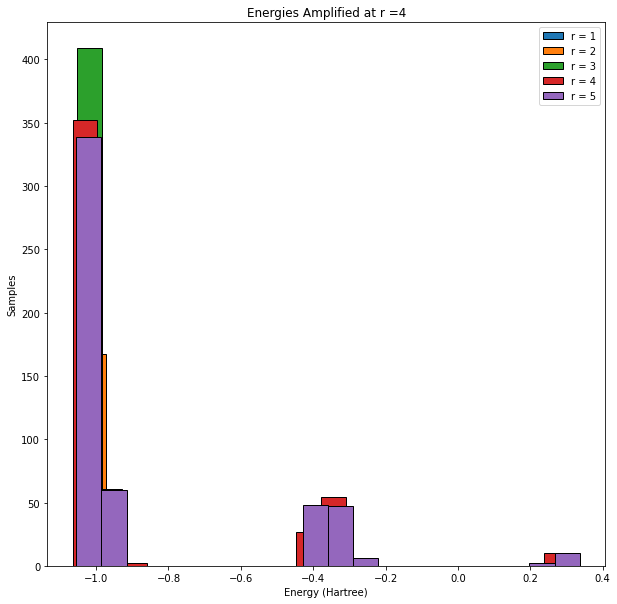

In [94]:
plt.figure(figsize= [10,10])
for r in range(1, 6):
    plt.hist(lots_scaled_expec_vals[r-1],  edgecolor = 'black',
             bins = int(0.2/0.01), label = 'r = ' + str(r))
# Add labels

plt.title('Energies Amplified at r =' + str(r-1))
plt.xlabel('Energy (Hartree)')
plt.legend()
plt.ylabel('Samples')
plt.show()

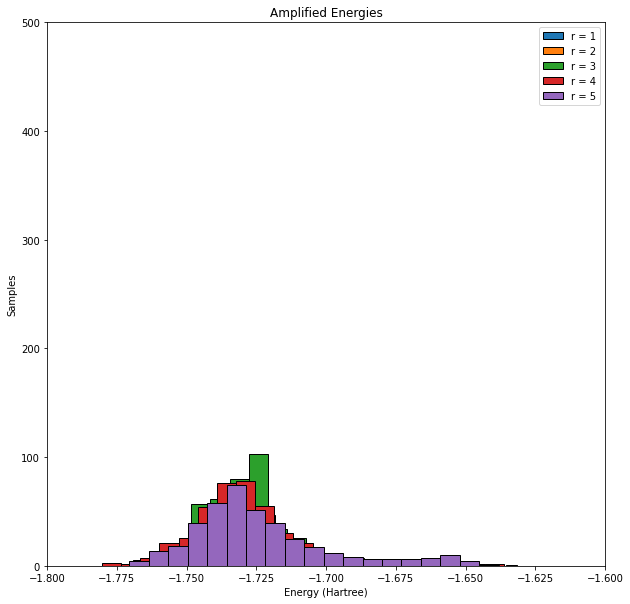

In [92]:
plt.figure(figsize= [10,10])
plt.axis([-1.8, -1.6, 0, 500])
for r in range(1, 6):
    plt.hist(lots_scaled_expec_vals[r-1],  edgecolor = 'black',
             bins = int(0.2/0.001), label = 'r = ' + str(r))
# Add labels

plt.title('Amplified Energies')
plt.xlabel('Energy (Hartree)')
plt.legend()
plt.ylabel('Samples')
plt.show()

In [95]:
import numpy as np
#Finding means 
means = []
for scale_expec_vals in lots_scaled_expec_vals:
    mean = np.mean(scale_expec_vals)
    means.append(mean)


Text(0.5, 1.0, 'Amplifying error via pauli conjugation in a VQE circuit of H2 --Yorktown noise simulated')

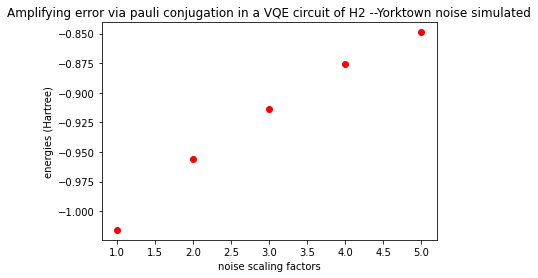

In [96]:
import matplotlib.pyplot as plt 
plt.plot([1,2,3,4,5], means, 'ro')
plt.xlabel('noise scaling factors')
plt.ylabel('energies (Hartree)')
plt.title('Amplifying error via pauli conjugation in a VQE circuit of H2 --Yorktown noise simulated')

In [92]:
shift

0.7151043390810812

In [97]:
means

[-1.0158495870053446,
 -0.9562953839718973,
 -0.9137335744321023,
 -0.875993061584202,
 -0.8488248296200906]

In [94]:
result = ExactEigensolver(qubitOp).run()
exact_energy = result['energy'] + shift
result['energy']

-1.852388173569582

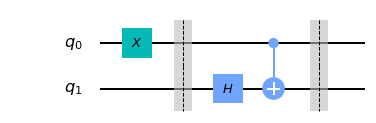

In [14]:
circ = QuantumCircuit(2)
circ.x(0)
circ.barrier([0,1])
circ.h(1)
circ.cx(0,1)
circ.barrier([0,1])
circ.draw(output = 'mpl')

In [8]:
circ.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nx q[0];\nbarrier q[0],q[1];\nh q[1];\nbarrier q[0],q[1];\n'

In [17]:
circ = create_Paulitwirled_and_noiseamplified_circuit(circ,4,two_error_map)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
x q[0];
barrier q[0],q[1];
h q[1];
barrier q[0],q[1];
y q[0];
barrier q[0],q[1];
y q[0];
z q[1];
cx q[0],q[1];
x q[0];
y q[1];
barrier q[0],q[1];
y q[0];
x q[1];
barrier q[0],q[1];
barrier q[0],q[1];



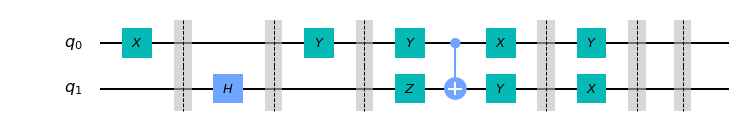

In [18]:
circ.draw(output = 'mpl')

In [62]:
I = [[1,0],[0,1]]
Z = [[1,0],[0,-1]]
ii = np.kron(I,I)
v, w = np.linalg.eig(ii)

In [63]:
v

array([1., 1., 1., 1.])

In [64]:
w

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])